In [37]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import pandas as pd
import nltk

import numpy as np

import tensorflow as tf


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors

In [4]:
GLOVE_DIR = "/content/drive/MyDrive/Fake News Res/glove.6B.100d.txt"


In [7]:
train = pd.read_csv('/content/drive/MyDrive/Fake News Res/dataset.csv')

In [11]:
train.head(3)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1


In [23]:
y = train['label'].values

In [15]:
comments_train = train['title']
comments_train = list(comments_train)

In [57]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")
    
texts = [] 

for line in tqdm_notebook(comments_train, total=72134): 
    texts.append(clean_text(line))

<ipython-input-57-f85d77dfa09b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(comments_train, total=72134):


  0%|          | 0/72134 [00:00<?, ?it/s]

In [58]:
print('Sample data:', texts[1], y[1])


Sample data:  1


In [59]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 46459


In [60]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (72134, 200)
Shape of label tensor: (72134,)


In [61]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [62]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  29710
validation:  7396


In [63]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  261     8  6447     7   219 15062 14563   841  5570     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [64]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/Fake News Res/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [65]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [66]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

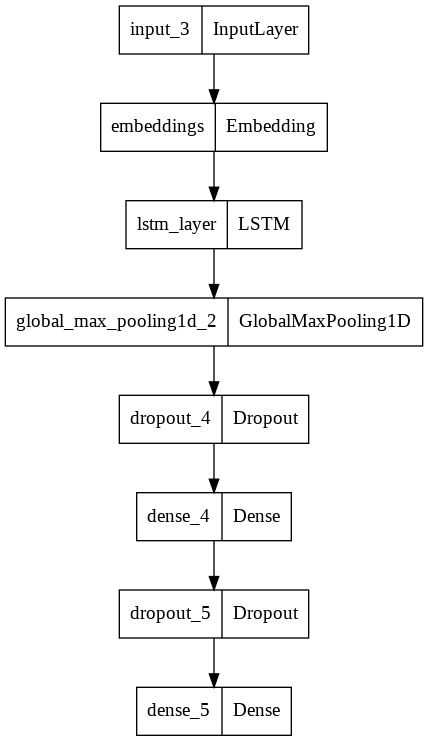

In [67]:
tf.keras.utils.plot_model(model)

In [68]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/10
1804/1804 [==============================] - 210s 115ms/step - loss: 0.3651 - accuracy: 0.8320 - val_loss: 0.2954 - val_accuracy: 0.8707
Epoch 2/10
1804/1804 [==============================] - 203s 113ms/step - loss: 0.2812 - accuracy: 0.8794 - val_loss: 0.2727 - val_accuracy: 0.8812
Epoch 3/10
1804/1804 [==============================] - 207s 115ms/step - loss: 0.2517 - accuracy: 0.8929 - val_loss: 0.2675 - val_accuracy: 0.8860
Epoch 4/10
1804/1804 [==============================] - 207s 115ms/step - loss: 0.2290 - accuracy: 0.9050 - val_loss: 0.2617 - val_accuracy: 0.8879
Epoch 5/10
1804/1804 [==============================] - 203s 112ms/step - loss: 0.2098 - accuracy: 0.9150 - val_loss: 0.2538 - val_accuracy: 0.8930
Epoch 6/10
1804/1804 [==============================] - 208s 115ms/step - loss: 0.1921 - accuracy: 0.9214 - val_loss: 0.2636 - val_accuracy: 0.8920
Epoch 7/10
1804/1804 [==============================] - 207s 115ms/step - loss: 0.1767 - accu

In [69]:
import matplotlib.pyplot as plt


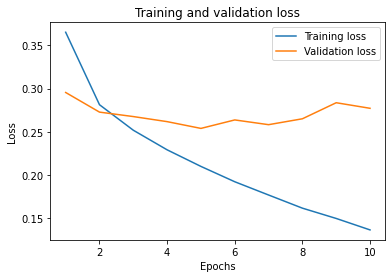

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

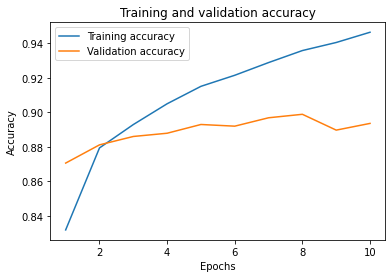

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();